In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
from tqdm.notebook import tqdm
import torch


cpu


## Data

(33, 3)
[[0.06747752 0.20290291 0.72961956]
 [0.24568461 0.46509192 0.28922347]
 [0.42851892 0.4680843  0.10339678]
 [0.00569654 0.74133444 0.25296902]
 [0.18787925 0.16200389 0.65011686]
 [0.27712784 0.48347074 0.23940142]
 [0.25117344 0.56549621 0.18333035]
 [0.03820861 0.24721561 0.71457579]
 [0.01473422 0.35686821 0.62839757]
 [0.49290601 0.34491509 0.1621789 ]
 [0.26046911 0.53890415 0.20062673]
 [0.35566519 0.29232281 0.35201199]
 [0.30175245 0.56989456 0.12835299]
 [0.25837077 0.04820561 0.69342362]
 [0.21085579 0.28216871 0.50697549]
 [0.54356641 0.38015178 0.07628181]
 [0.75494473 0.02935108 0.21570419]
 [0.14670059 0.44518519 0.40811422]
 [0.5744237  0.07284504 0.35273126]
 [0.13610738 0.33416172 0.5297309 ]
 [0.54465014 0.10922317 0.3461267 ]
 [0.3123573  0.61178259 0.07586011]
 [0.10261831 0.63899433 0.25838737]
 [0.72732982 0.06989817 0.202772  ]
 [0.23725133 0.2561955  0.50655317]
 [0.31534139 0.37710781 0.30755081]
 [0.17878748 0.70711781 0.11409472]
 [0.66717322 0.28238

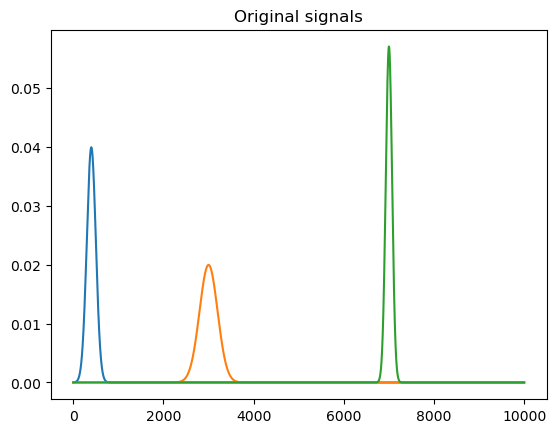

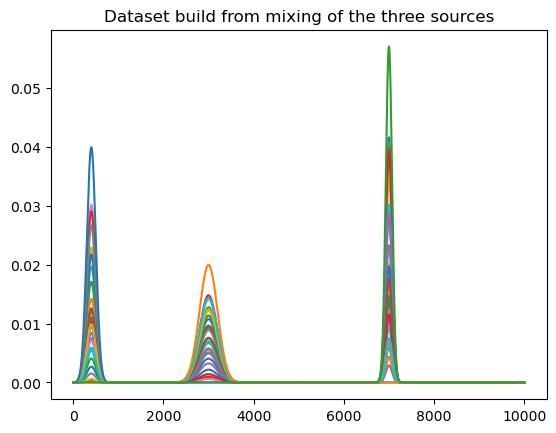

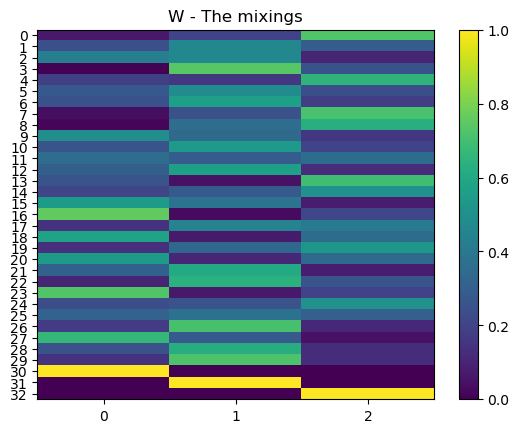

In [2]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 30, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3
print(W.shape)
print(W)

#W = np.random.rand(N, d)
# Random gaussian shifts
tau = np.zeros(shape=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)


plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The mixings")
plt.show()

## Regular NMF

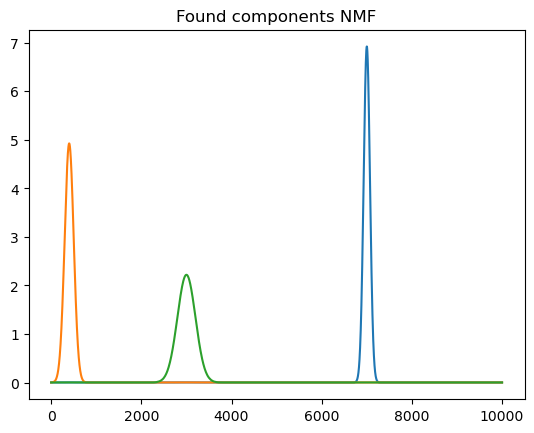

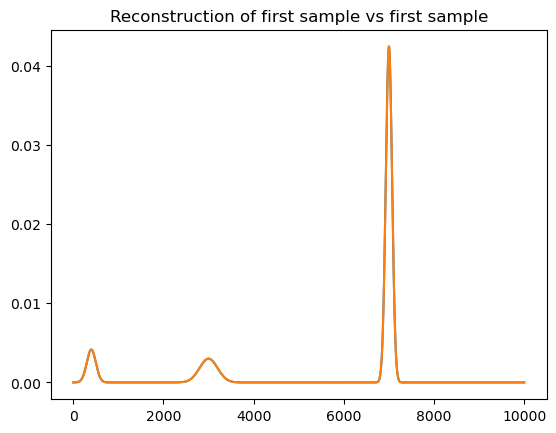

In [7]:

nmf = NMF(X, 3, lr=0.3, alpha=1/1000, factor = 0.8, patience=10)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

In [5]:

nmf = ShiftNMF(X, 3, lr=0.4, factor = 0.95, patience=5)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The recovered mixings")
plt.show()


KeyboardInterrupt: 

## Regular AA

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


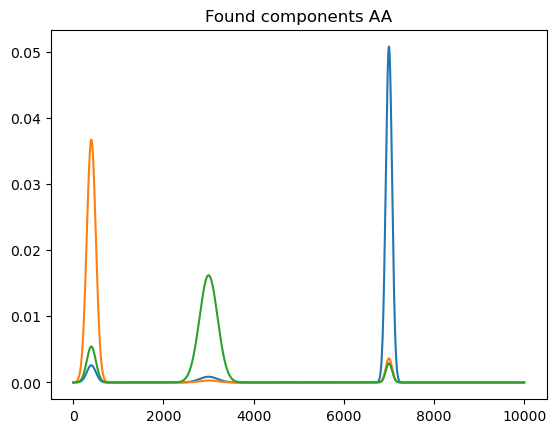

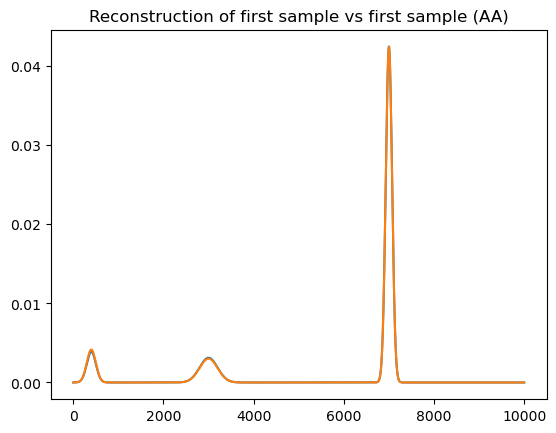

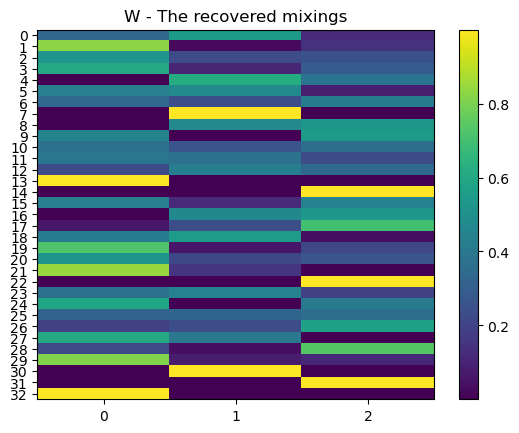

In [10]:
best_loss = np.inf
for _ in tqdm(range(20)):
    AA = torchAA(X, 3, lr=0.3, alpha=1/1000, factor=0.8, patience=5)
    C, S, loss = AA.fit(verbose=True, return_loss=True)
    if loss[-1] < best_loss:
        CX = np.matmul(C, X)
        recon = np.matmul(S, CX)
        best_loss = loss[-1]
        W = S

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The recovered mixings")
plt.show()


## Shift AA

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


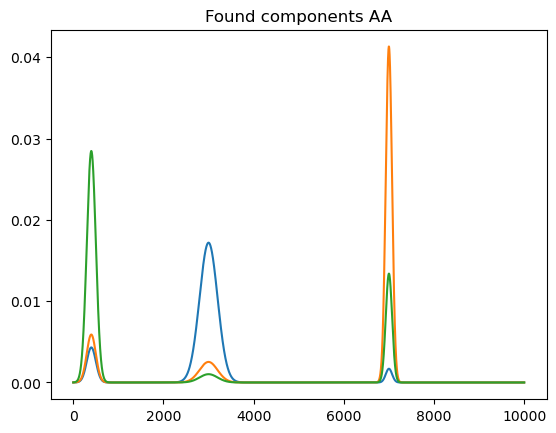

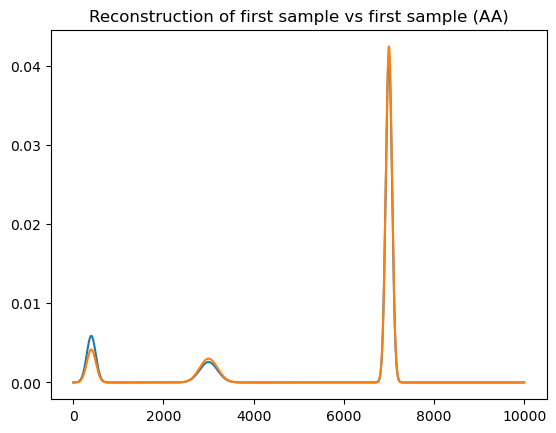

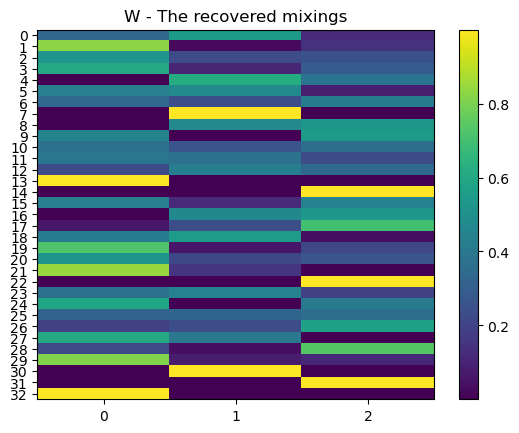

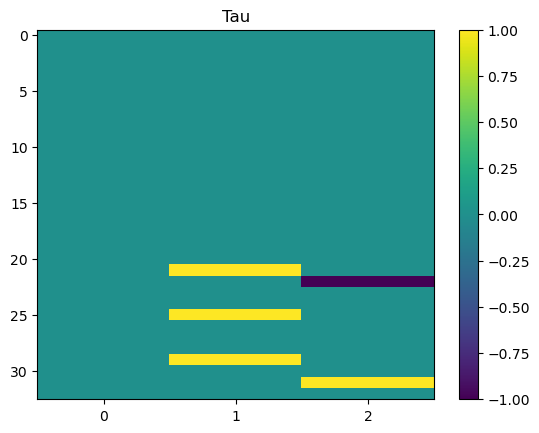

In [25]:
best_loss = np.inf
for _ in tqdm(range(1)):
    AA = torchShiftAA(X, 3, alpha=1/1000, lr=0.1, factor=0.95, patience=4)
    _, _, _, loss = AA.fit(verbose=True, return_loss=True)
    if loss[-1] < best_loss: 
        C, S, tau = AA.fit(verbose=True)
        recon = AA.recon.detach().resolve_conj().numpy()
        A = torch.fft.ifft(AA.A_F).detach().numpy()
        best_loss = loss[-1]

CX = A
SCX = recon

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The recovered mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()